# Aperture Photometry 1

In [348]:
from glob import glob
from astropy.io import fits
from astropy.visualization import hist
from astropy.modeling import fitting
from astropy.modeling.models import custom_model
fitter = fitting.LevMarLSQFitter()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import scipy.ndimage as ndi
import astropy.stats as astrostats

# configuration
np.set_printoptions(linewidth=120) # para que se vea

cmap = plt.get_cmap("inferno")
cmap.set_bad(color="r")
cmap.set_over(color="w")
if "astro" in plt.colormaps():
    colormaps.unregister("astro")
colormaps.register(cmap,name="astro")
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.cmap"] = "astro"
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.labelsize"] = 15



def quantile_linspace(arr,num=100,lower=0.01,upper=0.99):
    return np.linspace(*np.quantile(np.ravel(arr),[lower,upper]),num=num)

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

def quantile_hist(data,num=100,lower=0.01,upper=0.99):
    return plt.hist(np.ravel(data),bins=quantile_linspace(np.ravel(data),num,lower,upper))

def pseudomode(arr,sigma=1.6,maxiters=20):
    masked = astrostats.sigma_clip(arr,sigma=sigma,maxiters=maxiters)
    return arr[~masked.mask].mean()

# M 92

In [395]:
hdul = fits.open("data/M92.fits");
images = {hdu.name:hdu.data.astype(float) for hdu in hdul}
headers = {hdu.name:hdu.header for hdu in hdul}
hdul.close()

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  318                                                  
NAXIS2  =                  507                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
OBJECT  = 'M-92 V  '            /                                               
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '17-09-93'            /                                               
IRAFNAME= 'm92010.imh'          /  NAME OF IRAF IMAGE FILE                      
IRAF-MAX=           1.064900E4  /  DATA MAX                                     
IRAF-MIN=           4.810000

## Bias model

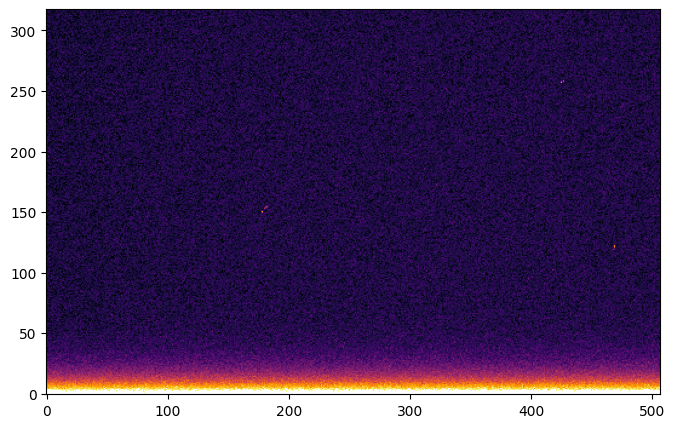

In [350]:
quantile_imshow(images["BIAS 25"].T)

In [351]:
def bias_model(x,y,/,m=0,b=1000,A=300,c=100,n=1):
    return m*x + b + n*x**2 + A*np.exp(-y/c)
BiasModel = custom_model(bias_model)
bias_model = BiasModel()

bias = images["BIAS 25"]
X,Y = np.mgrid[:bias.shape[0],:bias.shape[1]]
bias_model = fitter(bias_model,X,Y,bias)(X,Y)

In [352]:
flat = images["FLAT V 5"]
flat -= bias_model
flat /= flat.mean()

In [353]:
img = images["V 1"] - bias_model
img /= flat

In [354]:
img.shape

(507, 318)

## Source finding

### Masking

In [355]:
X,Y = np.mgrid[:img.shape[0],:img.shape[1]]

In [356]:
mask = (X>15) & (X<470) & (Y>10) & (Y<295)

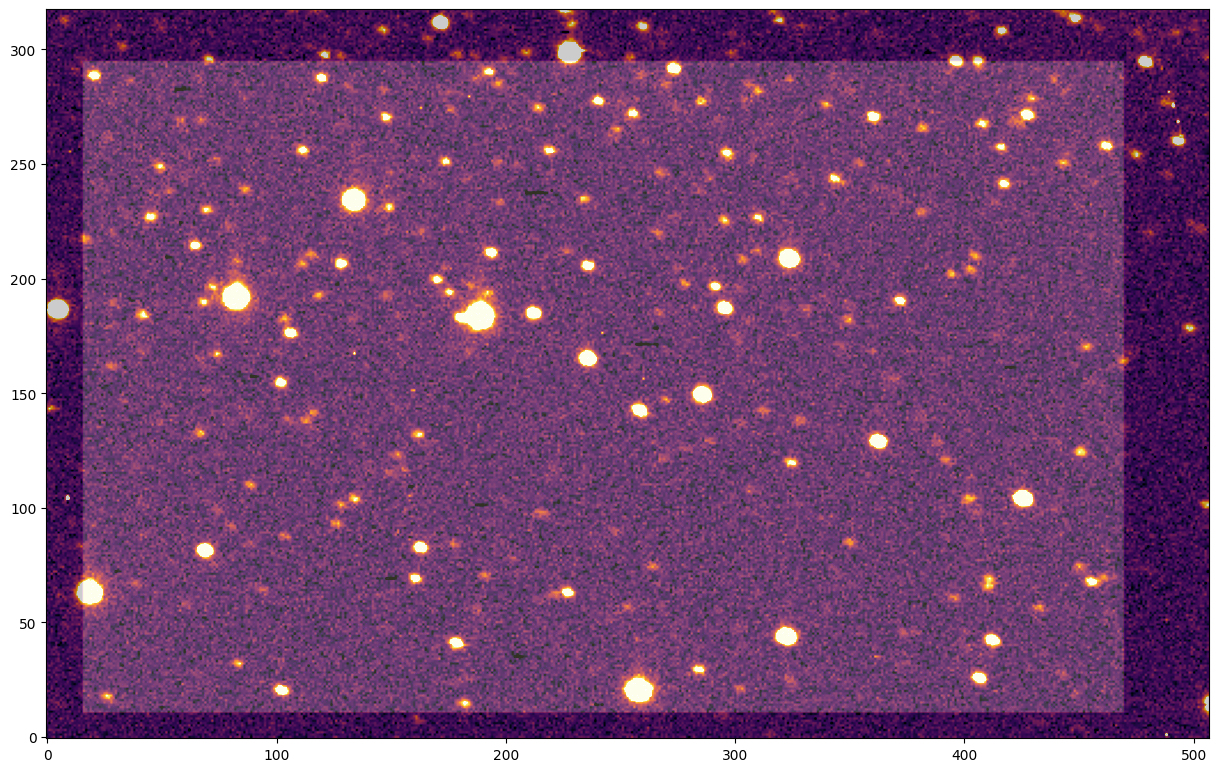

In [357]:
plt.figure(figsize=(15,15))
quantile_imshow(img.T)#,vmin=300,vmax=600)
plt.imshow(mask.T,alpha=0.2)

### Centroids

In [358]:
from skimage.feature import peak_local_max
from photutils.centroids import centroid_sources, centroid_quadratic # can be any of centroid_1dg, centroid_2dg, centroid_com, centroid_quadratic

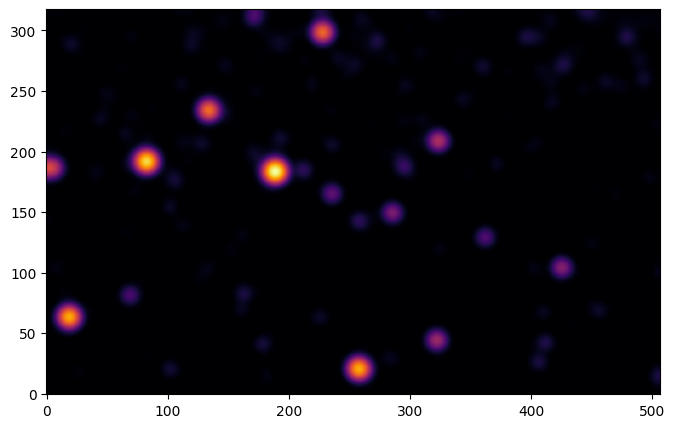

In [359]:
plt.imshow(ndi.gaussian_filter(img,5).T,vmin=50,norm="log")

In [360]:
peaks = peak_local_max(
    ndi.gaussian_filter(img,5),
    threshold_abs=60,
    labels=mask*1,
    min_distance=7,
    exclude_border=20
)

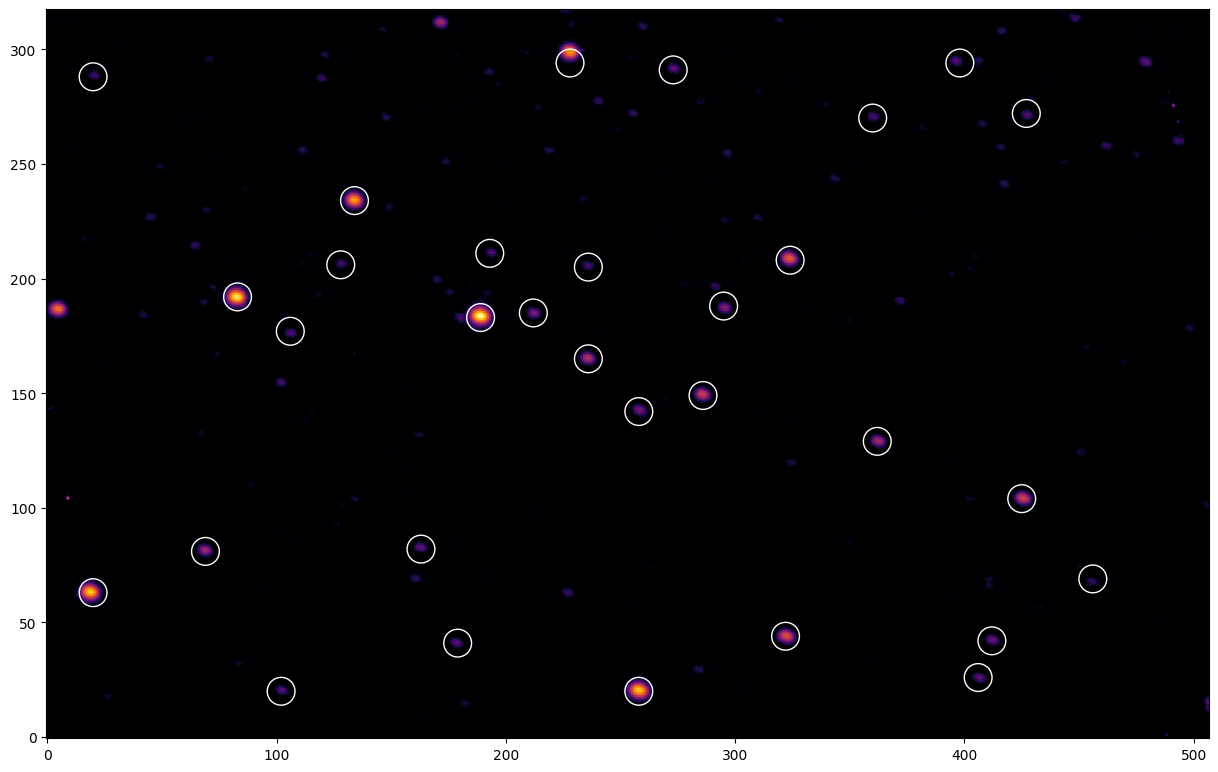

In [361]:
plt.figure(figsize=(15,15))
plt.imshow(img.T,vmin=70,norm="log")
plt.scatter(*peaks.T,fc="none",ec="w",s=400)

In [362]:
centroids = np.array(
    centroid_sources((img-img.mean()).T,*peaks.T,centroid_func=centroid_quadratic,box_size=9)
).T

In [363]:
distances = np.hypot(*(peaks-centroids).T)

In [364]:
distances

array([0.28080256, 0.37130066, 0.28730136, 1.20136411, 0.10249599, 4.        , 0.5912986 , 0.22040283, 0.4752492 ,
       0.33221334, 0.22951911, 0.32888746, 0.25233648, 1.13713082, 0.34511   , 0.58029173, 0.24186363, 1.05192569,
       0.2380493 , 1.75060874, 0.71126846, 0.55819171, 0.45562705, 1.01032325, 0.42065946, 0.23589815, 0.74441566,
       0.23839974, 0.74035829, 0.30675317, 1.45181064])

Text(0.5, 0, 'Distance correction [pix]')

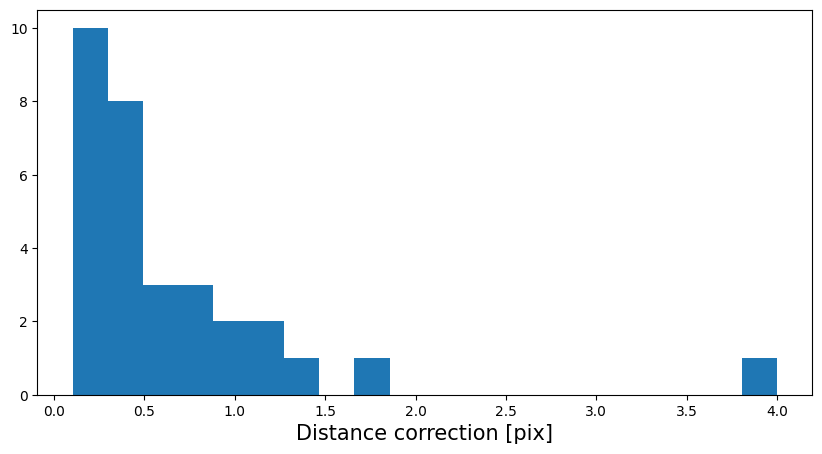

In [365]:
plt.hist(distances,bins=20);
plt.xlabel("Distance correction [pix]")

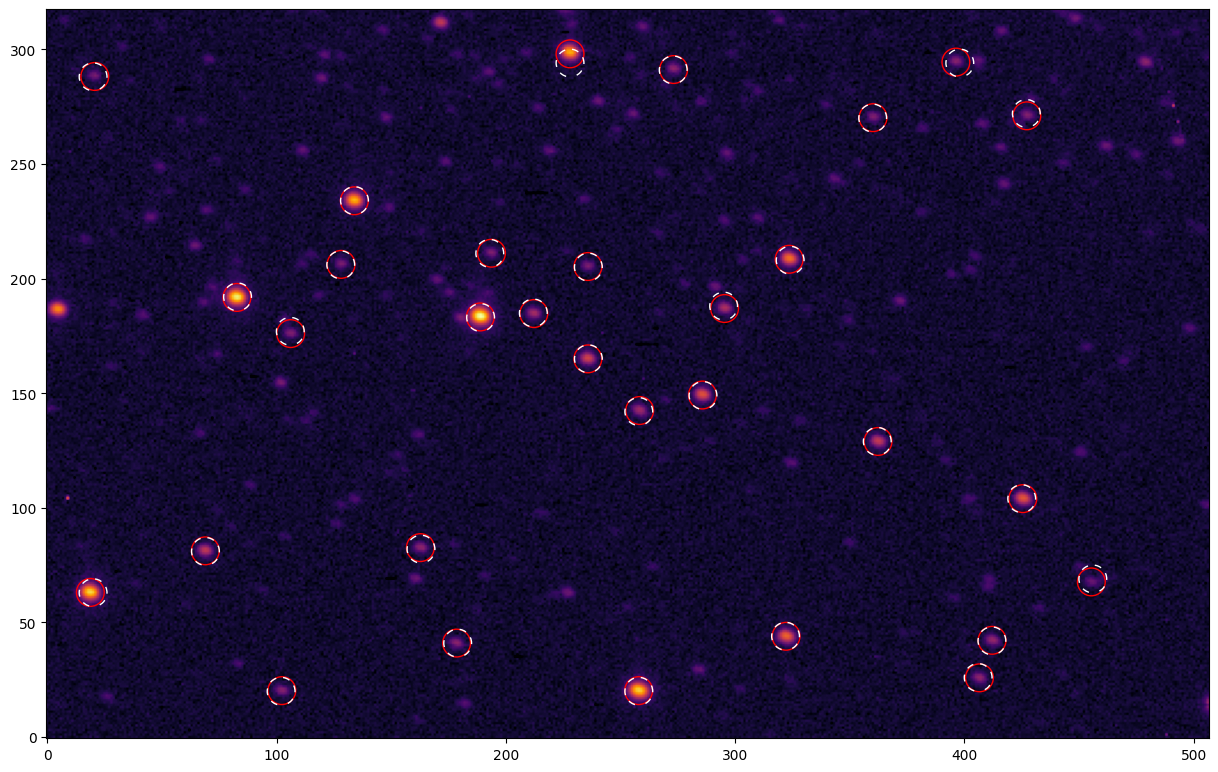

In [366]:
plt.figure(figsize=(15,15))
plt.imshow(img.T,vmin=30,norm="log")
plt.scatter(*centroids.T,fc="none",ec="r",s=400)
plt.scatter(*peaks.T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))

## Radial profile and FWHM

In [367]:
from photutils.aperture import CircularAperture, ApertureStats
from photutils.profiles import RadialProfile
from astropy.modeling.models import Gaussian1D,Voigt1D,Const1D
from astropy.modeling.fitting import LevMarLSQFitter
fitter = LevMarLSQFitter(calc_uncertainties=True)

In [368]:
model = Const1D(100) + Gaussian1D(5e3,0,1.5)
model.mean_1.fixed = True

In [369]:
radii = np.arange(0,10,1)
profile = RadialProfile(img.T,centroids[0],radii)
fitted_model = fitter(model,profile.radius,profile.profile)

In [370]:
params = []
params_std = []
for c in centroids:
    try:
        profile = RadialProfile(img.T,c,radii)
        fitted_model = fitter(model,profile.radius,profile.profile)
        params_std.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
        params.append(fitted_model.parameters)
    except ValueError:
        pass
    #plt.plot(profile.radius,profile.gaussian_profile)
    #plt.plot(profile.radius,profile.profile,". k")
    #plt.show()
    #plt.close()

params = np.asarray(params)
params_std = np.asarray(params_std)

In [371]:
x = np.log10(params.T[1])
y = 2*np.sqrt(2*np.log(2))*params.T[3]
dx = params_std.T[1]/params.T[1] / np.log(10)
dy = 2*np.sqrt(2*np.log(2))*params_std.T[2]


samples = np.random.normal(loc=y,scale=dy,size=(10_000,len(y)))
means = samples.mean(axis=1)

FWHM = means.mean()
FWHM_err = means.std()

Text(0.5, 1.0, 'FWHM mean = $3.690\\pm0.009$')

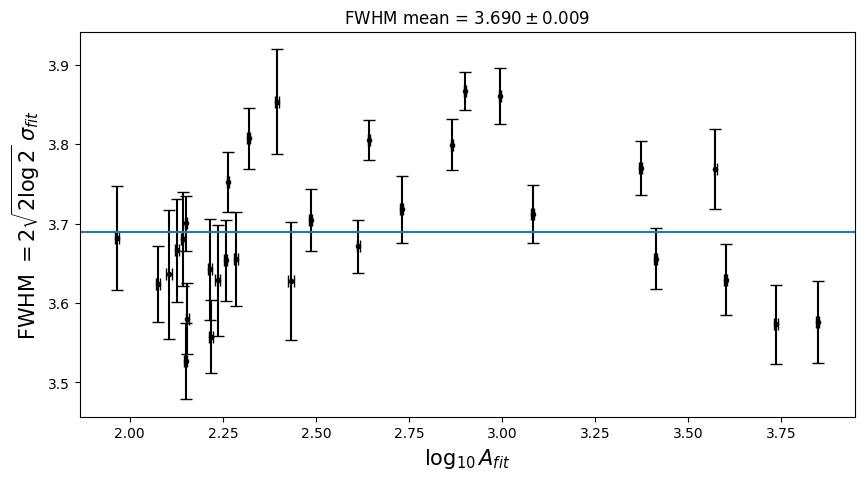

In [372]:
plt.errorbar(x,y,dy,dx,fmt=". k",capsize=4)

plt.xlabel("$\\log_{10} A_{fit}$")
plt.ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$")

plt.axhline(FWHM)
plt.title(f"FWHM mean = ${FWHM:.3f}\\pm{FWHM_err:.3f}$")

In [373]:
centroids

array([[188.88710947, 183.2571105 ],
       [ 82.71966112, 191.75653688],
       [257.91535108,  20.27454805],
       [ 18.80264234,  63.09803253],
       [133.94016228, 233.91678417],
       [228.        , 298.        ],
       [323.57148761, 208.40744468],
       [322.2197413 ,  43.98293638],
       [425.47475028, 104.02177081],
       [285.74076856, 149.20776133],
       [235.77253731, 164.96934477],
       [362.32482288, 128.94845332],
       [ 68.94824734,  81.24697239],
       [295.40309098, 186.93671068],
       [212.21165642, 184.7274152 ],
       [258.36822109, 142.4484994 ],
       [412.08073152,  42.22799219],
       [427.23105857, 270.97376436],
       [273.17863926, 291.15733876],
       [396.29454524, 294.39503801],
       [162.73127722,  82.65855211],
       [406.54062871,  25.86108067],
       [178.544694  ,  41.01710125],
       [106.15605261, 176.0018013 ],
       [102.31118287,  20.28305406],
       [360.15984735, 270.17348418],
       [193.74261322, 211.05177137],
 

In [374]:
FWHM

3.6899666302314733

amplitud en x y ancho en y, deberiamos velar porque no varie mucho la dispersion. Entre as tenue menos exacto es el fit lado debil donde hay mas puntos por eos uno coge los 30 mas brillantes 

In [375]:
centroids
#queremos calcular los vecinos mas cercanos a cada punto usaremos skitlearn

array([[188.88710947, 183.2571105 ],
       [ 82.71966112, 191.75653688],
       [257.91535108,  20.27454805],
       [ 18.80264234,  63.09803253],
       [133.94016228, 233.91678417],
       [228.        , 298.        ],
       [323.57148761, 208.40744468],
       [322.2197413 ,  43.98293638],
       [425.47475028, 104.02177081],
       [285.74076856, 149.20776133],
       [235.77253731, 164.96934477],
       [362.32482288, 128.94845332],
       [ 68.94824734,  81.24697239],
       [295.40309098, 186.93671068],
       [212.21165642, 184.7274152 ],
       [258.36822109, 142.4484994 ],
       [412.08073152,  42.22799219],
       [427.23105857, 270.97376436],
       [273.17863926, 291.15733876],
       [396.29454524, 294.39503801],
       [162.73127722,  82.65855211],
       [406.54062871,  25.86108067],
       [178.544694  ,  41.01710125],
       [106.15605261, 176.0018013 ],
       [102.31118287,  20.28305406],
       [360.15984735, 270.17348418],
       [193.74261322, 211.05177137],
 

In [376]:

#from sklearn.neighbors import NearestNeighbors

# denos los dos mas cercanos porque el primero es el mismo

In [377]:
#NearestNeighbors(n_neighbors=2).fit(centroids).kneighbors(centroids)[0][:,1].min() #VER HP


In [378]:
mindistance = 17.47

(42.77546605750122, 138.15219161509881)

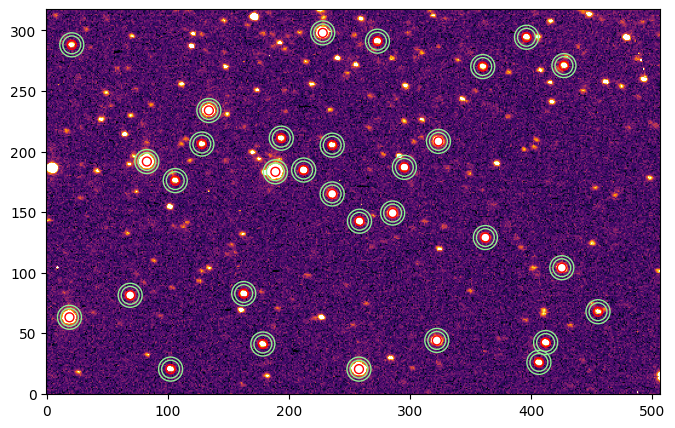

In [379]:
from photutils.aperture import CircularAnnulus

sky_apertures = CircularAnnulus(centroids, 2*FWHM, 0.72*(mindistance-FWHM)) #anillos de cielo
star_apertures = CircularAperture(centroids, FWHM)

quantile_imshow(img.T)
sky_apertures.plot(color= 'lightgreen') 
star_apertures.plot(color= 'red')

star_apertures.area, sky_apertures.area

In [380]:
FWHM

3.6899666302314733

In [381]:
1.2*FWHM

4.427959956277768

lo que no detectamos como estrella pero lo tomamos

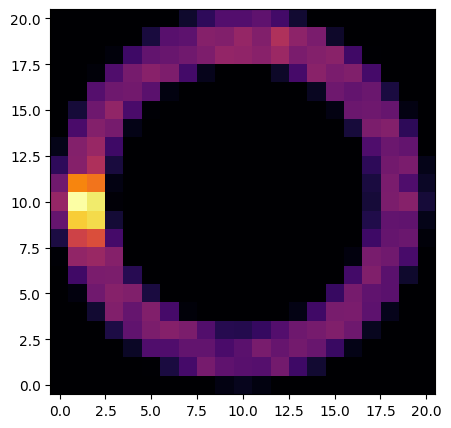

In [382]:
# calcular el valor de cielo y hacer histograma de eso

# suma de los pixeles del anillo y luego lo divides por el numero de pixeles, ese es el promedio y 

#necesitamos hacer mascara

plt.imshow(sky_apertures[0].to_mask().multiply(img.T) )# porcentajes de los pixeles que estan en el borde del anillo tonces cuanto hay dentro y fuera ya si

In [383]:
sky = sky_apertures[0].to_mask().get_values(img.T)

In [384]:
ApertureStats(img.T, sky_apertures).median #ESTOS SON LOS VALORES DE CIELO

array([68.00442465, 62.73320602, 58.06018071, 59.50136936, 55.42935704, 52.76344416, 50.60597139, 48.69246638,
       49.24158008, 48.30036603, 49.07991352, 48.94117845, 50.30352241, 50.06274772, 47.95186952, 46.49864034,
       47.77274468, 52.40157725, 50.23853571, 50.98119289, 46.91381493, 47.94502173, 48.26778862, 49.04678857,
       49.50611837, 48.77603055, 48.79675873, 47.8289372 , 48.66740242, 47.48019098, 49.64181472])

In [385]:
sky_values = ApertureStats(img.T, sky_apertures).sum / sky_apertures.area

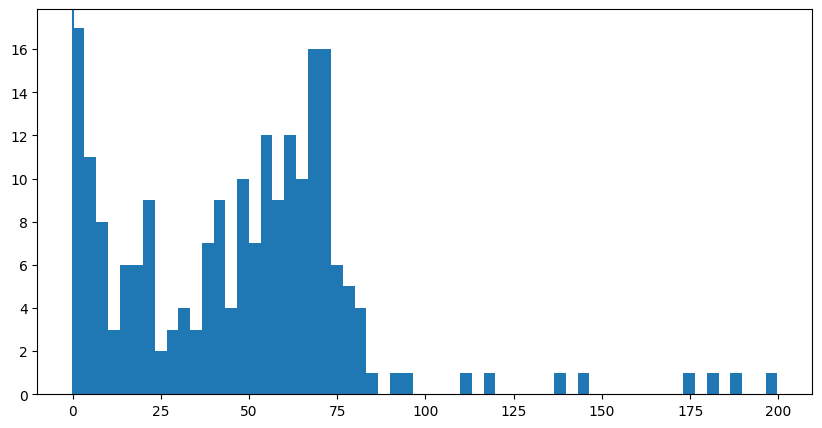

In [386]:
plt.hist(sky, 60)
plt.axvline()

ahora debemos buscar el valor de la señal

In [387]:
star_values = ApertureStats(img.T, star_apertures).sum / star_apertures.area
star_values

array([2475.40780623, 1909.98669224, 1438.97090922, 1444.7241185 ,  964.01135948,  917.6652997 ,  482.13753733,
        422.34609315,  348.24382248,  319.02173606,  242.74473707,  210.25190208,  194.20117409,  158.21036513,
        143.72111606,  142.31978686,  125.20529416,  104.31625221,  114.44227271,  107.85425734,  114.73908477,
        115.64943329,  109.04398232,   99.66281187,  104.67770764,   98.63356741,   96.34549294,   92.76004612,
         90.05368236,   95.04347959,   84.3385699 ])

Eso tiene una funcion que se llama apperture photometry de phototuil apperture y saca una tablita y uso la mediana para el cielo y sumo adentro y divido por el area. 

Tenemos los valores de las estrellas y los valores del cielo 

In [388]:
noc = star_values - sky_values
noc

array([2402.09954331, 1847.26285685, 1380.57561084, 1385.62906508,  908.65251075,  864.86807264,  431.38065215,
        373.38116671,  298.82762772,  270.79865505,  194.04851675,  161.10634114,  144.69261945,  104.82156024,
         95.26033967,   95.15632645,   77.66888892,   49.86313646,   64.06137679,   53.83885359,   66.52026311,
         67.72530892,   60.53468729,   49.61022155,   55.6958948 ,   49.70371111,   47.17631928,   45.09922964,
         40.54096907,   47.22216929,   33.4433241 ])

In [389]:
mag_instr = -2.5 * np.log10((star_values - sky_values) / headers['V 1']['EXPTIME']) 

In [390]:
mag_instr

array([-4.00609938, -3.72094362, -3.40477237, -3.40873934, -2.95061645, -2.89699654, -2.14177353, -1.9850029 ,
       -1.74317374, -1.63623813, -1.27439769, -1.07240346, -0.95573782, -0.60574842, -0.50190219, -0.50071604,
       -0.28023961,  0.20092914, -0.07111254,  0.11763862, -0.11200677, -0.13149936, -0.00963263,  0.20645021,
        0.08082016,  0.20440609,  0.26106799,  0.30995532,  0.42564281,  0.26001329,  0.63460453])

In [391]:
from photutils.aperture import aperture_photometry

aperture_photometry(img.T, star_apertures)



<QTable length=31>
  id       xcenter            ycenter          aperture_sum   
             pix                pix                           
int32      float64            float64            float64      
----- ------------------ ------------------ ------------------
    1 188.88710947328795 183.25711049590558 105886.72259391494
    2  82.71966111877842 191.75653688478675  81700.57092430814
    3   257.915351076582  20.27454804832275 61552.651285003594
    4  18.80264234456003 63.098032533544405 61798.747493306095
    5 133.94016228420037   233.916784166596   41236.0351864071
    6              228.0              298.0 39253.560879636076
    7   323.571487610537 208.40744468025264 20623.657863108867
    8  322.2197413010456  43.98293637694142 18066.050972177574
    9  425.4747502842163 104.02177080545943 14896.291808383874
  ...                ...                ...                ...
   22 406.54062870696214  25.86108066593116  4946.958408386483
   23 178.54469399540255   41.0171012477698  4664.407164485184
   24 106.15605260700139 176.00180129581454  4263.123226480104
   25 102.31118286707085 20.283054061477813  4477.637729921227
   26  360.1598473522593  270.1734841798516  4219.096814878589
   27 193.74261322060434 211.05177137193243  4121.223363256997
   28  128.1541774016053 206.18183444168395 3967.8542043837824
   29 20.728057631108722   288.134396728526 3852.0882332350416
   30 235.81505608108012 205.24473098156489 4065.5291352739237
   31 455.36565143316665  67.69410718811847 3607.6216342213984

In [398]:
#1 hora son 15 grados
z = headers['V 1']['ZD']
z = z.split(':')
grados = z[0]
minutos = z[1]
segundos = z[2]


#el error en la apertura 

['20', '17', '00.00']

In [ ]:
background = np.sqrt(25) * np.std(bias - bias_model)
bacimg = np.ones_like(bias) - background

from photutils.utils import calc_total_error

img_err = calc_total_error(img,bacimg, 

bias - bias_model 
y a eso le puedo sacar la desviacion estandar 
pero es un bias que es un promedio de 25 bias y eso cambia 
ruido de cada pixel de la imagen

calcular erro total 